Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
# from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.tree import plot_tree

In [3]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

#import os
#os.listdir()
#print(os.getcwd())
#os.chdir('c:\\Users\\Brian Wright\\Documents\\3001Python\\DS-3001')

movie_metadata=pd.read_csv("../data/movie_metadata.csv")
movie_metadata.head()


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

In [4]:
def preprocess(df):
    # Drop Columns with too many unique values
    # Keeping imdb score as the target variable
    df = df.drop(columns=['actor_1_name','actor_2_name','color','content_rating','actor_3_name','plot_keywords','movie_imdb_link'])

    # Collapse imdb score (target variable) into two classes 
    # name for new target variable is imdb_score_cat
    df['imdb_score_cat'] = pd.cut(df['imdb_score'], bins=[0, 7, 10], labels=[0, 1]).astype(int)
    df = df.drop(columns=['imdb_score'])

    # Classify director names mentioned more than 10 times with 1 and 0
    director_counts = df['director_name'].value_counts()
    df['director_name'] = df['director_name'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Classify country mentioned more than 10 times with 1 and 0
    df['country'] = df['country'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Classify language mentioned more than 10 times with 1 and 0
    df['language'] = df['language'].apply(lambda x: 1 if director_counts.get(x, 0) > 10 else 0)

    # Separate genres into different columns and encode them with 1 and 0
    genre_dummies = df['genres'].str.get_dummies(sep='|')
    df = df.join(genre_dummies)
    df.drop(columns=['genres'], inplace=True)
    
    return df

movie_metadata2 = preprocess(movie_metadata)

#3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [5]:
def fix_missing(df):
    # Drop Columns with too many missing values 
    df = df.dropna(thresh = int((1 - 0.4) * len(movie_metadata)), axis=1)
    
    # Drop missing values
    df = df.dropna()
    
    return df

movie_metadata3 = fix_missing(movie_metadata2)

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

In [6]:
print(movie_metadata3['imdb_score_cat'].value_counts(normalize=True)[1]) # Calculate the percentage of 1s in the target variable

0.3064982899237043


This number means the percentage of the higher range IMDB score, the target variables, in the dataset. This is also saying 30.64% of the films have a IMDB score higher than 7. 

#6 Split your data into test, tune, and train. (80/10/10)

In [7]:
def split_data(df, target, train_size=0.80, tune_size=0.50, random_state=21):
    # Split independent and dependent variables
    # Drop the target variable from the features
    X = df.drop(columns=target)
    y = df[target]
    
    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

X_train, X_tune, X_test, y_train, y_tune, y_test = split_data(movie_metadata3, 'imdb_score_cat')

# Drop 'movie_title' column from X_train, X_tune, X_test
X_train2 = X_train.drop(columns=['movie_title']).copy()
X_tune2 = X_tune.drop(columns=['movie_title']).copy()
X_test2 = X_test.drop(columns=['movie_title']).copy()


#7 Create the kfold object for cross validation.

In [8]:
kf = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42) # Define the cross-validation method

#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter 

In [9]:
scoring = ['roc_auc','recall','balanced_accuracy'] # scoring metric names I chose
param={"max_depth" : [1,2,3,4]} # hyperparameter space up to 4

#9 Build the classifier object 

In [10]:
from sklearn.tree import DecisionTreeClassifier
cl= DecisionTreeClassifier(criterion='gini', random_state=1000) # Establish the Decision Tree Model

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [11]:
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf,refit='roc_auc', verbose = 1) # Setting grid search

#11 Fit the model to the training data.

In [12]:
model = search.fit(X_train2, y_train)

Fitting 50 folds for each of 4 candidates, totalling 200 fits


#12 What is the best depth value?

In [14]:
best = model.best_estimator_ # Get the best estimator
print(model.best_params_) # Print the best parameters

{'max_depth': 4}


#13 Print out the model

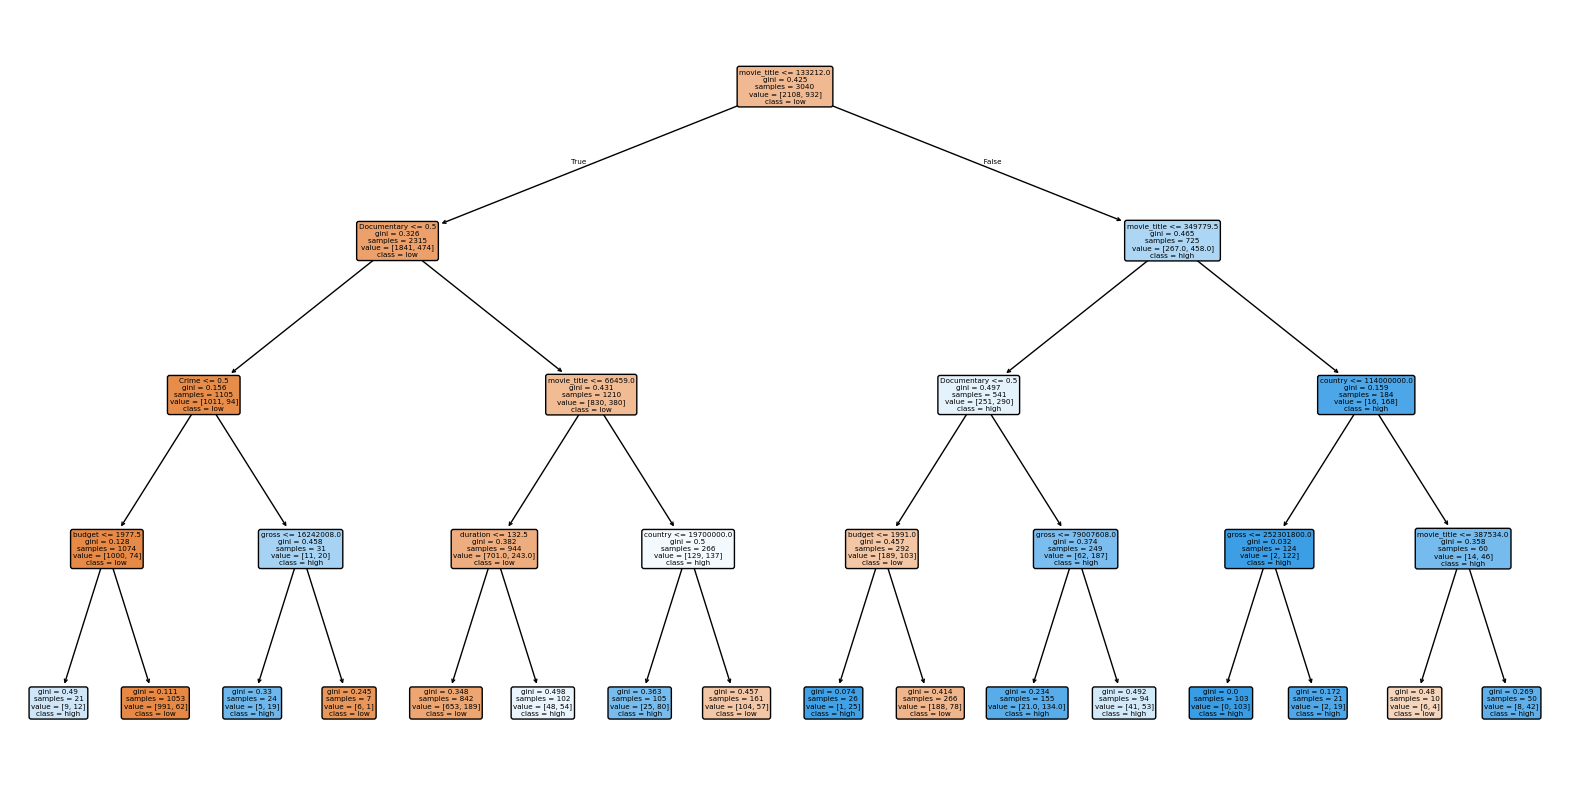

In [15]:
plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=['low', 'high'], filled=True, rounded=True)
plt.show()

#14 View the results, comment on how the model performed using the metrics you selected.

In [16]:
# Accuracy metrics with its mean and standard deviation:
auc = model.cv_results_['mean_test_roc_auc']
recall= model.cv_results_['mean_test_recall']
bal_acc= model.cv_results_['mean_test_balanced_accuracy']

SDauc = model.cv_results_['std_test_roc_auc']
SDrecall= model.cv_results_['std_test_recall']
SDbal_acc= model.cv_results_['std_test_balanced_accuracy']

# Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

# DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

print(final_model.head())

   depth       auc    recall   bal_acc     aucSD  recallSD  bal_accSD
0      1  0.665356  0.445784  0.665356  0.024946  0.056704   0.024946
1      2  0.757610  0.363594  0.643331  0.023472  0.082152   0.026542
2      3  0.797934  0.500652  0.702648  0.023608  0.062634   0.025210
3      4  0.812524  0.494633  0.707801  0.024578  0.058601   0.023594


Based on the results, the best model is max_depth = 4. The model improved in auc significantly from 0.66 to 0.8125 that means hows it has a fairly good ability of distinguishing classes. The recall goes down from 0.44 to 0.36 and up to 0.50, meaning it is able to capture more positive instances. The balanced accuracy also slightly improved with handling imbalanced data. The standard deviation metrics are relatively low as well, so the performances throughout are fairly consistent. 

#15 Which variables appear to be contributing the most (variable importance) 

In [17]:
# Variable importance computed by feature_importances_ attribute
var_imp = pd.DataFrame(best.feature_importances_, index=X_train2.columns, columns=['importance']).sort_values('importance', ascending=False)
print(var_imp)

                           importance
num_voted_users              0.560559
Drama                        0.213387
title_year                   0.066114
budget                       0.051610
Documentary                  0.041377
duration                     0.034987
gross                        0.031966
actor_3_facebook_likes       0.000000
director_facebook_likes      0.000000
num_critic_for_reviews       0.000000
actor_1_facebook_likes       0.000000
director_name                0.000000
language                     0.000000
num_user_for_reviews         0.000000
facenumber_in_poster         0.000000
cast_total_facebook_likes    0.000000
aspect_ratio                 0.000000
movie_facebook_likes         0.000000
country                      0.000000
actor_2_facebook_likes       0.000000
Adventure                    0.000000
Action                       0.000000
Animation                    0.000000
Biography                    0.000000
Crime                        0.000000
Comedy      

#16 Use the predict method on the tune data and print out the results.

In [18]:
y_pred = best.predict(X_tune2) # Predict the tune set
print(y_pred)

[0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0]


#17 How does the model perform on the tune data?

In [19]:
tune_accuracy = accuracy_score(y_tune, y_pred) # Accuracy score from sklearn.accuracy_score
print(f"Tuning Accuracy: {tune_accuracy * 100}%")

Tuning Accuracy: 78.42105263157895%


#18 Print out the confusion matrix for the tune data, what does it tell you about the model?

In [20]:
def adjust_thres(x, y, z):
    """
    x=pred_probabilities
    y=threshold
    z=tune_outcome
    """
    thres = pd.DataFrame({'new_preds': [True if i > y else False for i in x]}) # boolean prediction based on threshold
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = metrics.confusion_matrix(z, thres) # Comparing true labels and predicted labels
    print(con_mat)


adjust_thres(y_pred, 0.5, y_tune)

[[241  23]
 [ 59  57]]


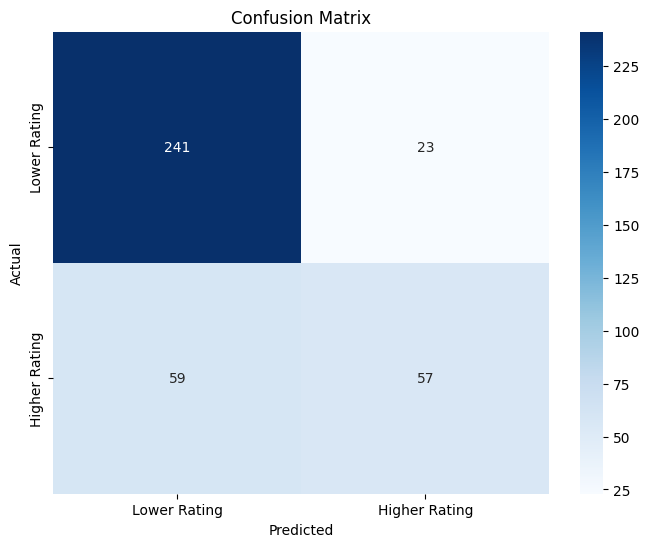

In [21]:
conf_matrix = confusion_matrix(y_tune, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Lower Rating', 'Higher Rating'],
            yticklabels=['Lower Rating', 'Higher Rating'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

According to the confusion matrix, the model has 23 false positives and 59 false negatives. Although the model is not perfect, it is still able to capture a good amount of positive instances.

#19 What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?

In [22]:
# Add predicted probabilities to the dataset
X_tune['predicted_prob'] = model.predict_proba(X_tune2)[:,1]

# Sort the dataset by predicted probabilities in descending order
sorted_dataset = X_tune.sort_values(by='predicted_prob', ascending=False)

# Select the top 3 movies
top_3_movies = sorted_dataset.head(3)

# Display the top 3 movies
print(top_3_movies[['movie_title', 'predicted_prob']])

            movie_title  predicted_prob
1406   Horrible Bosses              1.0
2250     Into the Wild              1.0
2174  12 Years a Slave              1.0


In [23]:
# Filter variable importance for the top 3 movies
top_3_var_imp = var_imp[var_imp['importance'] > 0]
print(top_3_var_imp)

                 importance
num_voted_users    0.560559
Drama              0.213387
title_year         0.066114
budget             0.051610
Documentary        0.041377
duration           0.034987
gross              0.031966


#20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

In [24]:
param2 = {
    "max_depth":  [1,2,3,4,5,6,7,8,9,10,11],  # Number of features increase
    'ccp_alpha' :[.001, .01, .1] # Minimum impurity decrease
}
cl= DecisionTreeClassifier(criterion='gini', random_state=1000)
search = GridSearchCV(cl, param2, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc', verbose = 1)
model2 = search.fit(X_train2, y_train)
best2 = model2.best_estimator_
best2

Fitting 50 folds for each of 33 candidates, totalling 1650 fits


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, random_state=1000)

In [25]:
# Accuracy metrics:
auc = model2.cv_results_['mean_test_roc_auc']
recall= model2.cv_results_['mean_test_recall']
bal_acc= model2.cv_results_['mean_test_balanced_accuracy']

SDauc = model2.cv_results_['std_test_roc_auc']
SDrecall= model2.cv_results_['std_test_recall']
SDbal_acc= model2.cv_results_['std_test_balanced_accuracy']

# Parameter:
depth= np.unique(model2.cv_results_['param_max_depth']).data

# DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

print(final_model.head())

   depth       auc    recall   bal_acc     aucSD  recallSD  bal_accSD
0      1  0.665356  0.445784  0.665356  0.024946  0.056704   0.024946
1      2  0.757610  0.363594  0.643331  0.023472  0.082152   0.026542
2      3  0.798103  0.500865  0.702754  0.023394  0.062649   0.025180
3      4  0.812677  0.494846  0.707859  0.024586  0.058639   0.023636
4      5  0.823248  0.533635  0.723933  0.027754  0.059428   0.025291


#21 Did the model improve with the new hyperparameter search?

The model did improve with a new hyperparameter search. I first increased the depth, which allows the model to find the best depth value. In addition, I changed the ccp_alpha by setting it to [.001, .01, .1] that will prune the decision tree that adjusts the complexity and simplicity of the model. The model improved in auc  from 0.8125 to 0.822, recall improves from 0.49 to 0.53, and balanced accuracy slightly improved. The standard deviation are consistently low throughout. 

#22 Using the better model, predict the test data and print out the results.

In [26]:
y_pred = best2.predict(X_test2)
print(y_pred)

[0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0]


In [27]:
adjust_thres(y_pred, 0.5, y_test)

[[248  16]
 [ 56  61]]


#23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.

Along the way, I noticed that there are some plausible key features that determine the ratings of a movie. Features, such as num_voted_users, genre (i.e. Drama), and budget of a movie are important when it comes to predicting the ratings of a movie. For my recommendation to my boss, I would suggest  experimenting more with the hyper-parameters in order to see how the new movies will perform based on the features that are important. For the results I got for the top 3 movies, it would be accurate to say "12 Years a Slave" is a highly rated movie, however, "Horrible Bosses" does not seem like a reasonable result. In addition, I would also recommend trying other models, such as Linear Regression, that can quantitatively predict the performance of a movie using linear combinations of parameters to predict the specific score. Even though variable importance shows the variables that are important, it does not mean they accurately predict the ratings of a movie. The variables that are split in the decision tree are not always the best predictors of the ratings of a movie. Therefore, I would use this model with other parameters to get a sense of where this movie will lie when it comes in being a higher region or lower region of the IMDB score.